In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from math import factorial

### 1) Simulación recurrencia n perros

1. Funciones auxiliares

In [28]:
#plotea P_t(m) en 3d
def plots(n_fleas,n_steps,Z):
    
    y = np.linspace(0,n_steps,n_steps+1)
    x = np.linspace(0,n_fleas, n_fleas+1)
    X, Y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(Y,X, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.plot_wireframe(Y,X, Z, rstride=10, cstride=10)
    plt.show()
    
    im = plt.imshow(Z, cmap='hot', aspect='auto')
    plt.colorbar(im, orientation='vertical')
    plt.show()

### Recurrencia para n perros y N pulgas:
### $P_{t+1} = \frac{m+1}{N} P_t(m+1) + \frac{N-(m-1)}{N} \frac{1}{n-1} P_t(m-1) + \frac{N-m}{N} \frac{n-2}{n-1} P_t(m)$

In [29]:
def initialize(n_steps,n_fleas):
    P = np.zeros((n_steps+1,n_fleas+1))
    P[0,0] = 1
    return P
    
    
def Recurrence(a,b,c,m,n_fleas,ndogs):
    d = (m+1)/n_fleas*a+(n_fleas+1-m)/(n_fleas*(n_dogs-1))*b+ (n_dogs-2)*(n_fleas-m)/(n_fleas*(n_dogs-1))*c
    return d
    
def Recurrence_bound(a,b,n_fleas,n_dogs,flag):
    if flag == 0:
        d = a/n_fleas + (n_dogs-2)*(n_fleas)/(n_fleas*(n_dogs-1))*b
    else:
        d = a/(n_fleas*(n_dogs-1))
    return d
    
#Obtiene P_(t+1) dado P_t  
def get_next(P_t,n_fleas,n_dogs):
    
    P_next = np.zeros(n_fleas+1)
    P_next[0] = Recurrence_bound(P_t[1],P_t[0],n_fleas,n_dogs,0)
    for m in range(1,n_fleas):
        P_next[m] = Recurrence(P_t[m+1],P_t[m-1],P_t[m],m,n_fleas,n_dogs)
    P_next[-1] = Recurrence_bound(P_t[n_fleas-1],0,n_fleas,n_dogs,1)
    
    return P_next


def evolve(P_vector,n_fleas,n_dogs,t):
    for time in range(t):
        P_vector[time+1][:] = get_next(P_vector[time],n_fleas,n_dogs)


### Main

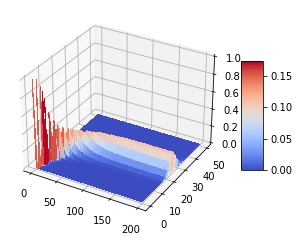

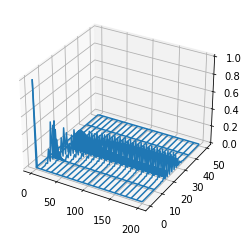

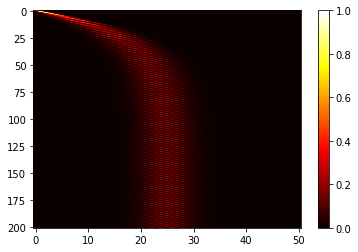

In [30]:
n_dogs = 2
n_fleas = 50
n_steps = 200
P_vector = initialize(n_steps,n_fleas) # contiene las probabilidades en el tiempo
evolve(P_vector,n_fleas,n_dogs,n_steps)
plots(n_fleas,n_steps,P_vector)

### 2) Simulación con numeros aleatorios

In [74]:
def multinomial(lst,n):
    m = factorial(n)
    for i in lst:
        m *= 1/factorial(i)
    return m

def max_value(n_fleas,n_dogs):
    k = int(n_fleas)//n_dogs
    r = n_fleas-k*n_dogs
    max_v = multinomial([k]*(n_dogs-r)+[k+1]*r,n_fleas)
    if n_fleas != 1:
        max_v = np.log(max_v) 
    return max_v


def get_current_Entropy(d_state,n_fleas):
    return np.log(multinomial(d_state,n_fleas))

In [87]:
#Hay dos arreglos:
#f_state contiene en la casilla i el perro actual en el que se encuentra la pulga i (enumerando las pulgas de 0 a nfleas-1)
#d_state contiene en la casilla i el numero de pulgas actuales que se encuentran en el (enumerando los perros de 0 a ndogs-1)

#se incializan las pulgas toas en un mismo perro
def initialize_state(n_fleas,n_dogs):
    f_state = [0]*n_fleas #casilla i-esima --> pulga_i en perro f_state[i]
    d_state = [0]*n_dogs #casilla i-esima --> num de pulgas en perro i
    d_state[0] = n_fleas
    return f_state, d_state

#elgie uniformemente una pulga
def fRandom(n_fleas):
    n1 = np.random.randint(n_fleas)
    return n1

#elige uniformemente un perro que no tiene a la pulga que saltará
def dRandom(n_dogs,n):
    n1 = np.random.randint(n_dogs-1)
    if(n1 >= n):
        n1 += 1
    return n1

#Actualiza f_state y d_state en un solo salto. Pseudocodigo:
#Elige pulga n1 (se encuentra en perro_n1) --->  elige perro en el que no estuviera la pulga n1 (perro_n2) ---> actualiza
# numero de pulgas en perro_n1 -=1 , numero de pulgas en perro_n2 +=1, pulga n1 ahora está en perro_n2
def update(f_state,d_state,n_fleas,n_dogs):
    n1 = fRandom(n_fleas)
    dog_n1 = f_state[n1]
    dog_n2 = dRandom(n_dogs,dog_n1)
    d_state[dog_n1] -= 1
    d_state[dog_n2] += 1
    f_state[n1] = dog_n2

#actualiza f_state y d_state en steps pasos, y crea un vector Hist cuya entrada i-esima es el numero de pulgas
#que tiene el perro 0 en el paso i-esimo
def evolve(f_state,d_state,n_fleas,n_dogs,steps):
    Entropy =  np.zeros(steps+1)
    Entropy[0] = get_current_Entropy(d_state,n_fleas)
    Hist = [0]*(steps+1)
    Hist[0] = d_state[0]
    for step in range(steps):
        update(f_state,d_state,n_fleas,n_dogs)
        Hist[step+1] = d_state[0]
        Entropy[step+1] = get_current_Entropy(d_state,n_fleas)
    return Hist,Entropy

#corre la simulación steps pasos
def simulate(n_fleas,n_dogs,steps):
    f_state,d_state = initialize_state(n_fleas,n_dogs)
    Hist,Entropy = evolve(f_state,d_state,n_fleas,n_dogs,steps)
    return Hist,Entropy

In [88]:
#plots functions

def plot_hist(Hist,n_fleas,steps,x_lim):
    plt.hist(Hist, bins= n_fleas,density = True,range=(0,x_lim))
    plt.title("Histograma de pulgas en el perro 0 despues de "+str(steps)+" pasos")
    plt.xlabel('Número de pulgas',size=12)
    plt.ylabel('Probabilidad',size=12)
    plt.show()
    
def plot_numf_vs_time(Hist,steps,y_lim_axis):
    plt.plot(Hist,'-o',ms = 0.2)
    plt.title("Número de Pulgas en el perro 0 con el paso del tiempo\n para "+str(steps)+" pasos")
    plt.ylabel('Número de pulgas',size=12)
    plt.xlabel('Pasos en el tiempo',size=12)
    plt.ylim(0,y_lim_axis)
    plt.show()

def plot_Bzmann_S(Entropy,steps,y_lim0,y_lim1,flag = 0):
    plt.plot(np.linspace(0,steps,steps+1),Entropy)
    plt.title("Entropia de Boltzmann con el paso del tiempo\n para "+str(steps)+" pasos")
    plt.ylabel('Entropia',size=12)
    plt.xlabel('Pasos en el tiempo',size=12)
    plt.ylim(y_lim0,y_lim1)
    if(flag != 0):
        plt.xscale("log")
    plt.show()

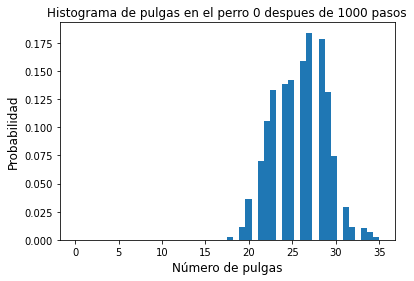

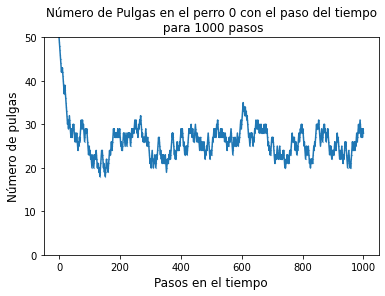

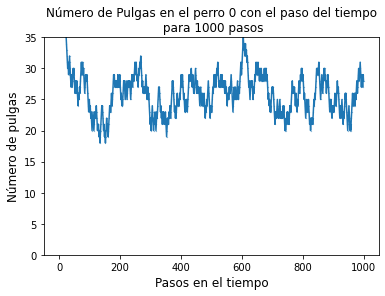

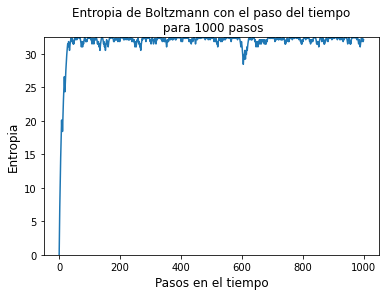

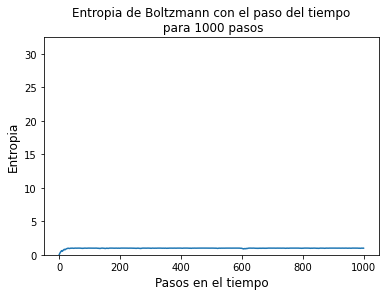

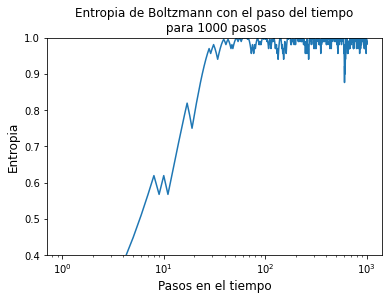

In [92]:
n_fleas = 50
n_dogs = 2
steps = 1000
lim = n_fleas/n_dogs + 2*(n_fleas*(n_dogs-1)/n_dogs)**0.5 # limita el eje y en promedio + 2*varianza , valido para n_fleas > n_dogs
Hist,Entropy = simulate(n_fleas,n_dogs,steps)
mv = max_value(n_fleas,n_dogs)
Entropy_norm = Entropy/mv #Entropia normalizada
plot_hist(Hist,n_fleas,steps,lim)
plot_numf_vs_time(Hist,steps,n_fleas)
plot_numf_vs_time(Hist,steps,lim)
plot_Bzmann_S(Entropy,steps,0,mv)
plot_Bzmann_S(Entropy_norm,steps,0,mv)
plot_Bzmann_S(Entropy_norm,steps,0.4,1,1)

### Si se desea correr la simulación para un numero grande de plugas, corra las siguientes casillas:
Esto se debe a que el cálculo de factoriales es computacionalmente complejo, lo cual se requiere en el calculo de la entropia

In [81]:
#plots functions

def plot_hist(Hist,n_fleas,steps):
    plt.hist(Hist, bins= n_fleas,density = True)
    plt.title("Histograma de pulgas en el perro 0 despues de "+str(steps)+" pasos")
    plt.xlabel('Número de pulgas',size=12)
    plt.ylabel('Probabilidad',size=12)
    plt.show()
    
def plot_numf_vs_time(Hist,steps):
    plt.plot(Hist,'-o',ms = 0.2)
    plt.title("Número de Pulgas en el perro 0 con el paso del tiempo\n para "+str(steps)+" pasos")
    plt.ylabel('Número de pulgas',size=12)
    plt.xlabel('Pasos en el tiempo',size=12)
    plt.show()

def plot_Bzmann_S(Entropy,steps,flag = 0):
    plt.plot(np.linspace(0,steps,steps+1),Entropy)
    plt.title("Entropia de Boltzmann con el paso del tiempo\n para "+str(steps)+" pasos")
    plt.ylabel('Entropia',size=12)
    plt.xlabel('Pasos en el tiempo',size=12)
    if(flag != 0):
        plt.xscale("log")
    plt.show()
    
def evolve(f_state,d_state,n_fleas,n_dogs,steps):
    Hist = [0]*(steps+1)
    Hist[0] = d_state[0]
    for step in range(steps):
        update(f_state,d_state,n_fleas,n_dogs)
        Hist[step+1] = d_state[0]
    return Hist

#corre la simulación steps pasos
def simulate(n_fleas,n_dogs,steps):
    f_state,d_state = initialize_state(n_fleas,n_dogs)
    Hist = evolve(f_state,d_state,n_fleas,n_dogs,steps)
    return Hist

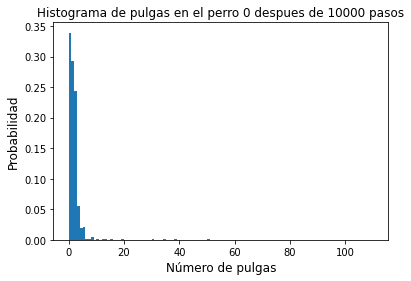

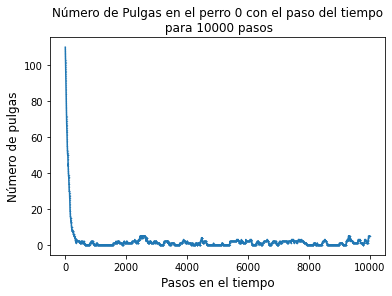

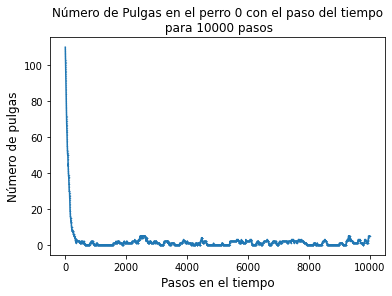

In [82]:
n_fleas = 110
n_dogs = 109
steps = 10000
lim = n_fleas/n_dogs + 2*(n_fleas*(n_dogs-1)/n_dogs)**0.5 # limita el eje y en promedio + 2*varianza , valido para n_fleas > n_dogs
Hist = simulate(n_fleas,n_dogs,steps)
plot_hist(Hist,n_fleas,steps)
plot_numf_vs_time(Hist,steps)
plot_numf_vs_time(Hist,steps)